# Import Library

In [1]:
%pip install ultralytics -q
%pip install segmentation_models_pytorch -q
%pip install torchmetrics -q
%pip install torch torchvision torchaudio -q
%pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.6 MB/s eta 0:00:00


In [54]:
import os
import shutil
import pandas as pd
import numpy as np
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
import math

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Get Model & Image

## Food Segmentation Model

### Unzip Food Segmentation Model

In [4]:
!unzip /content/yolo_food_segmenttaion_model.zip

Archive:  /content/yolo_food_segmenttaion_model.zip
   creating: yolo_food_segmenttaion_model/
  inflating: yolo_food_segmenttaion_model/best.pt  


### Load Food Segmentation Model

In [5]:
food_model = YOLO("/content/yolo_food_segmenttaion_model/best.pt")

## Coin Segmentation Model

### Unzip Coin Segmentation Model

In [6]:
!unzip /content/yolo_coin_segmentation_model.zip

Archive:  /content/yolo_coin_segmentation_model.zip
   creating: yolo_coin_segmentation_model/
  inflating: yolo_coin_segmentation_model/best.pt  


### Load Coin Segmentaion Model

In [8]:
coin_model = YOLO("/content/yolo_coin_segmentation_model/best.pt")

## Image Path

In [114]:
img_path = "/content/food-coin-7.jpg"

# Predict Food Segmentation

## Predict Food

In [115]:
food_results = food_model(img_path)


image 1/1 /content/food-coin-7.jpg: 480x640 1 Ayam Goreng - Paha, 2 Ayam Goreng - Sayaps, 1 Nasi Putih, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


## Display Result

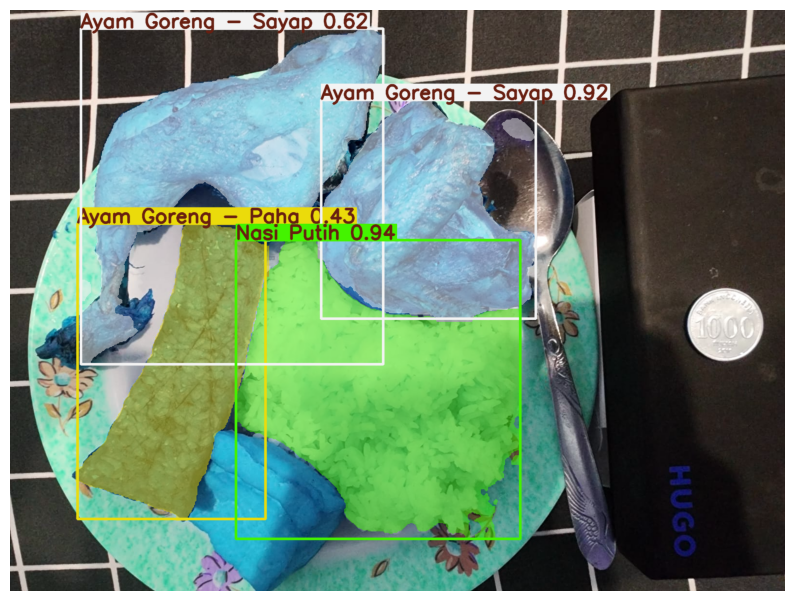

In [116]:
food_img_result = food_results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(food_img_result)
plt.axis("off")
plt.show()

## Get Detected Food Class Name

In [117]:
food_class_ids = food_results[0].boxes.cls.cpu().numpy().astype(int)
food_class_names = [food_results[0].names[class_id] for class_id in food_class_ids]

display(food_class_ids)
display(food_class_names)

array([8, 2, 2, 1])

['Nasi Putih',
 'Ayam Goreng - Sayap',
 'Ayam Goreng - Sayap',
 'Ayam Goreng - Paha']

## Get Detected Food Confidences

In [118]:
food_confidences = food_results[0].boxes.conf.cpu().numpy()
food_confidences = food_confidences.tolist()

food_confidences

[0.9444049596786499,
 0.9151331186294556,
 0.6225557923316956,
 0.43357613682746887]

## Get Mask from Detected Food

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
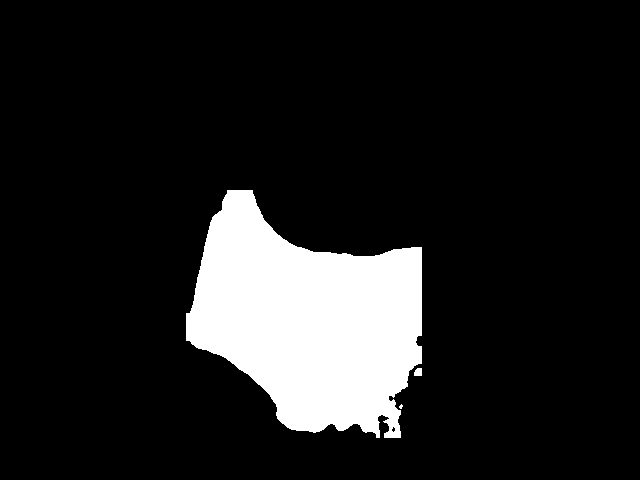

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
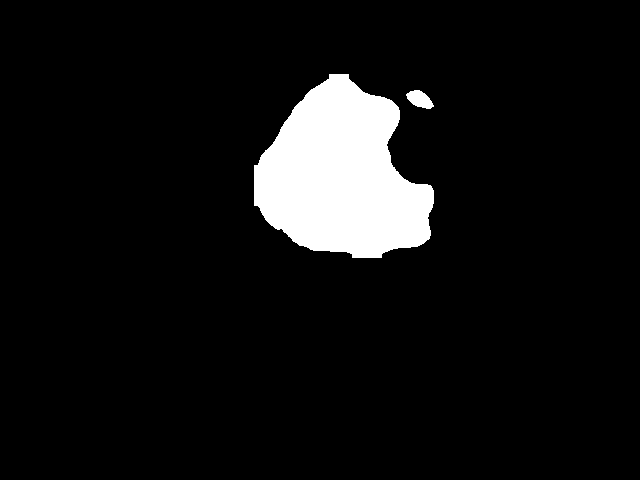

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
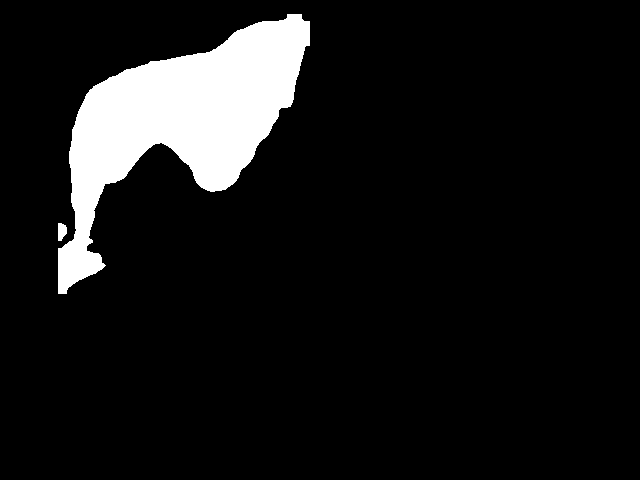

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
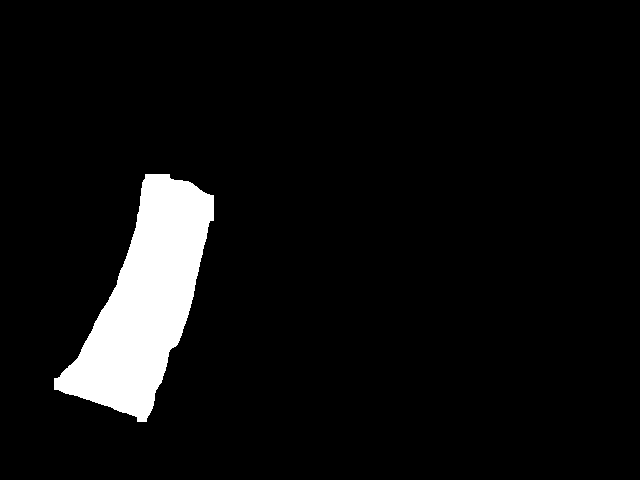

In [119]:
food_masks = food_results[0].masks.data.cpu().numpy()
food_masks = ((food_masks > 0.5).astype(np.uint8)) * 255

for mask in food_masks:
  display(mask)

## Resize Food Mask to Original Size

In [120]:
resize_food_masks = []

# Resize coin mask to original image size
h, w = food_results[0].orig_shape

for food_mask in food_masks:
  resize_mask = cv2.resize(food_mask, (w, h), interpolation=cv2.INTER_NEAREST)
  resize_food_masks.append(resize_mask)

resize_food_masks = np.array(resize_food_masks)
resize_food_masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

## Get Food Length & Width in Pixel

In [121]:
food_sizes = []

for mask in resize_food_masks:
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(contours, key=cv2.contourArea)

  leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
  rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
  topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
  bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

  length_px = np.linalg.norm(np.array(leftmost) - np.array(rightmost))
  width_px = np.linalg.norm(np.array(topmost) - np.array(bottommost))

  food_sizes.append({"length": length_px, "width": width_px})

for idx, size in enumerate(food_sizes):
  print(f"{food_class_names[idx]}: Length: {size['length']} px | Width: {size['width']} px")

Nasi Putih: Length: 602.32632351575 px | Width: 722.1807253035767 px
Ayam Goreng - Sayap: Length: 459.1481242475025 px | Width: 462.525674963023 px
Ayam Goreng - Sayap: Length: 807.2651361231947 px | Width: 903.8418003168475 px
Ayam Goreng - Paha: Length: 560.0446410778341 px | Width: 619.3230174957168 px


# Predict Coin Segmentation

## Predict Coin

In [122]:
coin_results = coin_model(img_path)


image 1/1 /content/food-coin-7.jpg: 480x640 2 coins, 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


## Display Result

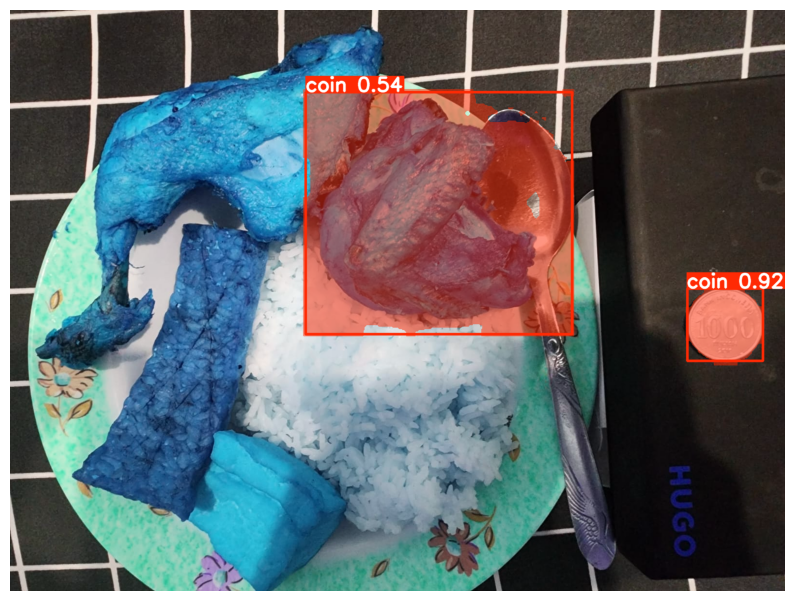

In [123]:
coin_img_result = coin_results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(coin_img_result)
plt.axis("off")
plt.show()

## Get Coin Detected Class Name

In [124]:
coin_class_ids = coin_results[0].boxes.cls.cpu().numpy().astype(int)
coin_class_names = [coin_results[0].names[class_id] for class_id in coin_class_ids]

display(coin_class_ids)
display(coin_class_names)

array([0, 0])

['coin', 'coin']

## Get Detected Coin Confidence

In [125]:
coin_confidences = coin_results[0].boxes.conf.cpu().numpy()
coin_confidences = coin_confidences.tolist()

coin_confidences

[0.9195136427879333, 0.5423461198806763]

## Get Best Confidence Coin

In [143]:
best_idx = np.argmax(coin_confidences)
best_coin_conf = coin_confidences[best_idx]

print(f"Best coin confidence: {best_coin_conf:.2f}")

Best coin confidence: 0.92


## Get Mask from Best Detected Coin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
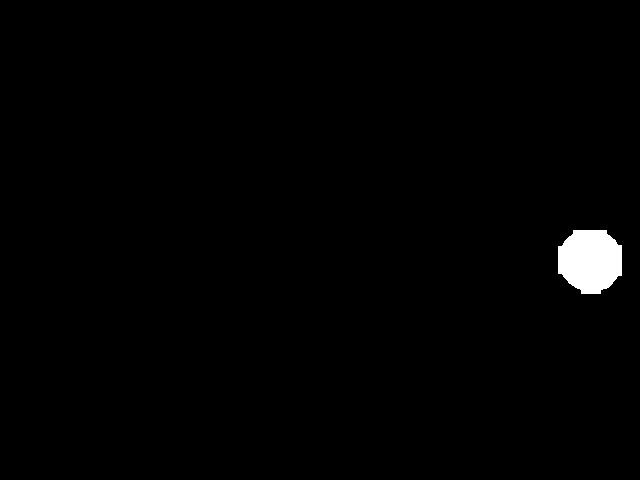

In [156]:
coin_mask = coin_results[0][best_idx].masks.data.cpu().numpy()
coin_mask = ((coin_mask > 0.5).astype(np.uint8)) * 255

coin_mask = coin_mask.squeeze()
coin_mask

## Resize Food Mask to Original Size

In [158]:
# Resize coin mask to original image size
h, w = coin_results[0].orig_shape
resize_coin_mask = cv2.resize(coin_mask, (w, h), interpolation=cv2.INTER_NEAREST)

resize_coin_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Get Coin Length & Width in Pixel

In [159]:
contours, _ = cv2.findContours(resize_coin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=cv2.contourArea)
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])
length_px = np.linalg.norm(np.array(leftmost) - np.array(rightmost))
width_px = np.linalg.norm(np.array(topmost) - np.array(bottommost))
coin_size = {"length": length_px, "width": width_px}

print(f"{coin_class_names[best_idx]}: Length: {size['length']} px | Width: {size['width']} px")

coin: Length: 756.0171955716352 px | Width: 509.0 px


# Depth Estimation with MiDaS

## Load MiDaS

In [31]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:47<00:00, 29.1MB/s]


In [32]:
transform = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transform.dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## Load Image

In [130]:
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to("cpu")

## Predict Image Depth

In [131]:
with torch.no_grad():
    prediction = midas(input_batch)

# Resize back to original image size
prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False,
).squeeze()

depth_map = prediction.cpu().numpy()

## Display Result

### Comparison Between Result & Original Image

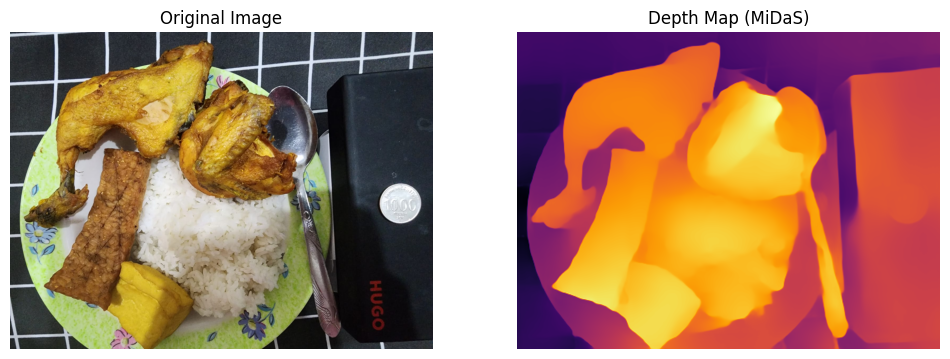

In [132]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap='inferno')
plt.title("Depth Map (MiDaS)")
plt.axis('off')

plt.show()

### Depth Score on Plot

Higher score mean closer to camera

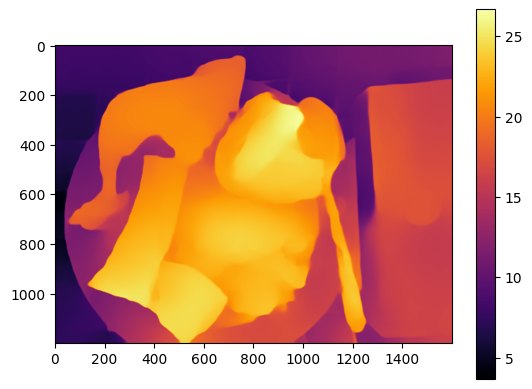

In [133]:
plt.imshow(depth_map, cmap="inferno")
plt.colorbar()
plt.show()

## Get Food Depth Score

### Get Median of Food Mask Depth Score

In [134]:
food_depths = []

for resize_mask in resize_food_masks:
  food_depth = np.median(depth_map[resize_mask > 0])
  food_depths.append(food_depth)

food_depths = np.array(food_depths)
food_depths

array([      22.56,      23.625,      19.965,      22.576], dtype=float32)

## Get Coin Depth Score

### Get Median of Coin Mask Depth Score

In [161]:
coin_depth = np.median(depth_map[resize_coin_mask > 0])

coin_depth

np.float32(17.567684)

# Get Value in cm with Coin Object

## Get Real Coin Diameter & Thickness in cm

In this project using Indonesia Coin 1000 Rupiah<Br>
The Values are in cm<br>
As there is resource limitation all food density will be 1g/cm<sup>3</sup>

In [136]:
REAL_COIN_DIAMETER = 2.41
REAL_COIN_THICKNESS = 0.16
FOOD_DENSITY = 1

## Calculate Length & Width cm/pixel

In [162]:
length_pixel = coin_size["length"]
width_pixel = coin_size["width"]

cm_per_px_length = REAL_COIN_DIAMETER / length_pixel
cm_per_px_width = REAL_COIN_DIAMETER / width_pixel

print(f"Length Pixel: {length_pixel} px")
print(f"Width Pixel: {width_pixel} px")
print(f"Length: {cm_per_px_length} cm/px")
print(f"Width: {cm_per_px_width} cm/px")

Length Pixel: 175.37673733993344 px
Width Pixel: 160.25292509030842 px
Length: 0.013741845335671216 cm/px
Width: 0.015038727053761273 cm/px


## Calculate Depth cm/depth unit

### Get Background Depth Around Coin Mask

In [163]:
bg_only = (resize_coin_mask == 0)
near_coin = cv2.dilate(resize_coin_mask, np.ones((25,25), np.uint8))  # add padding around coin mask
ring_bg = np.logical_and(near_coin, bg_only)

bg_depth = np.median(depth_map[ring_bg])

bg_depth

np.float32(17.270649)

### Calculate Distance Depth from Background to Coin

In [164]:
depth_difference = abs(coin_depth - bg_depth)
print(f"Coin Depth: {coin_depth}")
print(f"Background Depth: {bg_depth}")
print(f"Depth difference: {depth_difference}")

Coin Depth: 17.567684173583984
Background Depth: 17.270648956298828
Depth difference: 0.29703521728515625


### Calculate cm/depth unit

In [165]:
cm_per_depth_unit = REAL_COIN_THICKNESS / depth_difference

print(f"Depth: {cm_per_depth_unit} cm/depth unit")

Depth: 0.5386566519737244 cm/depth unit


# Estimation Food Real Length, Width, Depth, Area, and Volume

All foods will be considered as cube<br>
The result also in cm & gram

In [141]:
food_real_size = []

for idx, food_class_id in enumerate(food_class_ids):
  food_length = food_sizes[idx]["length"] * cm_per_px_length
  food_width = food_sizes[idx]["width"] * cm_per_px_width
  food_depth = food_depths[idx] * cm_per_depth_unit
  food_area = food_length * food_width
  food_volume = food_length * food_width * food_depth
  food_weight = food_volume * FOOD_DENSITY
  food_real_size.append({"class_id": food_class_id,
                         "class_name": food_class_names[idx],
                         "length": food_length,
                         "width": food_width,
                         "depth": food_depth,
                         "area": food_area,
                         "volume": food_volume,
                         "weight": food_weight})
food_real_size

[{'class_id': np.int64(8),
  'class_name': 'Nasi Putih',
  'length': np.float64(8.2770751793569),
  'width': np.float64(10.860678811327837),
  'depth': np.float32(12.152065),
  'area': np.float64(89.89465502020904),
  'volume': np.float64(1092.4057158679304),
  'weight': np.float64(1092.4057158679304)},
 {'class_id': np.int64(2),
  'class_name': 'Ayam Goreng - Sayap',
  'length': np.float64(6.30954250957273),
  'width': np.float64(6.955797381125607),
  'depth': np.float32(12.725524),
  'area': np.float64(43.887899264186686),
  'volume': np.float64(558.4965131431993),
  'weight': np.float64(558.4965131431993)},
 {'class_id': np.int64(2),
  'class_name': 'Ayam Goreng - Sayap',
  'length': np.float64(11.093312645484511),
  'width': np.float64(13.592630134745269),
  'depth': np.float32(10.754475),
  'area': np.float64(150.78729575916353),
  'volume': np.float64(1621.6381482599058),
  'weight': np.float64(1621.6381482599058)},
 {'class_id': np.int64(1),
  'class_name': 'Ayam Goreng - Paha',

# Combine Image Result of Food and Coin Segmentation

## Combining box, mask, and class name

In [222]:
food_boxes = food_results[0].boxes.xyxy.cpu().numpy()
coin_box = coin_results[0][best_idx].boxes.xyxy.cpu().numpy()
best_coin_class_name = coin_class_names[best_idx]

combine_boxes = np.concatenate([food_boxes, coin_box], axis=0)
combine_masks = np.concatenate([food_masks, [coin_mask]], axis=0)
combine_class_name = np.concatenate([food_class_names, [best_coin_class_name]])
combine_confidences = np.concatenate([food_confidences, [best_coin_conf]])

## Preparing Image

In [220]:
# Copy original image
img_combined = img.copy()

# Loop combine result
for i in range(len(combine_boxes)):
    box = combine_boxes[i]
    mask = combine_masks[i]
    cls_name = combine_class_name[i]
    conf = combine_confidences[i]

    # Coloring each object
    color = tuple(np.random.randint(0, 255, 3).tolist())

    # --- Draw Mask ---
    mask_resized = cv2.resize(mask.astype(np.uint8), (img_combined.shape[1], img_combined.shape[0]))
    img_combined[mask_resized > 0.5] = (
        img_combined[mask_resized > 0.5] * 0.5 + np.array(color) * 0.5
    ).astype(np.uint8)

    # --- Draw Bounding Box ---
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img_combined, (x1, y1), (x2, y2), color, 2)

    # --- Draw Label ---
    label = f"{cls_name} {conf:.2f}"
    font_scale = 1.2       # 🔹 ukuran font lebih besar
    font_thickness = 3     # 🔹 ketebalan font
    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    text_w, text_h = text_size

    # Background for teks
    cv2.rectangle(img_combined, (x1, y1 - text_h - 10), (x1 + text_w + 5, y1), color, -1)
    cv2.putText(
        img_combined, label, (x1 + 2, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness
    )

## Display Result

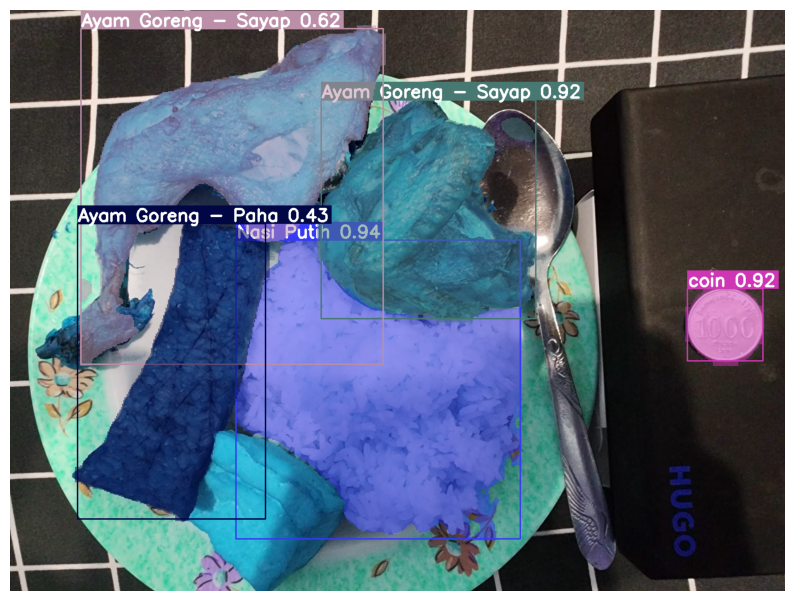

In [221]:
# --- Display Result ---
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()